# Optimizing QAOA using BO

## Setup

In [ ]:
import tensorcircuit as tc
import tensorflow as tf
import cotengra as ctg
import optax
import networkx as nx
import time
import numpy as np
import torch
import os

K = tc.set_backend("tensorflow")

## QAOA blackbox

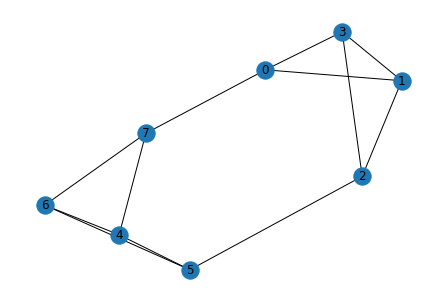

In [2]:
# Generate a graph
def dict2graph(d):
    g = nx.to_networkx_graph(d)
    for e in g.edges:
        if not g[e[0]][e[1]].get("weight"):
            g[e[0]][e[1]]["weight"] = 1.0
    nx.draw(g, with_labels=True)
    return g


# a graph instance
example_graph_dict = {
    0: {1: {"weight": 0.9}, 7: {"weight": 0.4}, 3: {"weight": 0.38}},
    1: {0: {"weight": 0.44}, 2: {"weight": 0.67}, 3: {"weight": 0.62}},
    2: {1: {"weight": 0.21}, 3: {"weight": 0.87}, 5: {"weight": 0.72}},
    4: {7: {"weight": 0.34}, 6: {"weight": 0.53}, 5: {"weight": 0.45}},
    7: {4: {"weight": 0.45}, 6: {"weight": 0.63}, 0: {"weight": 0.59}},
    3: {1: {"weight": 0.12}, 2: {"weight": 0.21}, 0: {"weight": 0.68}},
    6: {7: {"weight": 0.34}, 4: {"weight": 0.33}, 5: {"weight": 0.96}},
    5: {6: {"weight": 0.18}, 4: {"weight": 0.79}, 2: {"weight": 0.17}},
}

example_graph = dict2graph(example_graph_dict)

In [3]:
def QAOAansatz(params, g=example_graph):
    n = len(g.nodes)  # the number of nodes
    c = tc.Circuit(n)
    for i in range(n):
        c.H(i)
    # PQC
    for j in range(nlayers):
        # U_j
        for e in g.edges:
            c.exp1(
                e[0],
                e[1],
                unitary=tc.gates._zz_matrix,
                theta=g[e[0]][e[1]].get("weight", 1.0) * params[2 * j],
            )
        # V_j
        for i in range(n):
            c.rx(i, theta=params[2 * j + 1])

    # calculate the loss function
    loss = 0.0
    for e in g.edges:
        loss += g[e[0]][e[1]].get("weight") * c.expectation_ps(z=[e[0], e[1]])

    return K.real(loss)

## Using BO optimizer from ODBO


In [5]:
import odbo

# BO settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
batch_size = 1
acqfn = "ucb"

QAOA_nograd = K.jit(QAOAansatz)


def eval_objective(x, example_graph):
    """This is a helper function we use to unnormalize and evalaute a point"""
    a = tf.convert_to_tensor(np.array(x).ravel())
    return -QAOA_nograd(a, example_graph).numpy()


X_new = np.random.uniform(low=0, high=1, size=[1, 2 * nlayers])
X_bo = torch.tensor(np.vstack([initial_X, X_new]))
Y_bo = torch.tensor(
    [eval_objective(x, example_graph) for x in X_bo], dtype=dtype, device=device
).unsqueeze(-1)

In [6]:
# BO Optimizer
for i in range(100):  # run 100 iter optimizations
    X_next, acq_value, ids = odbo.run_exp.bo_design(
        X=X_bo,
        Y=Y_bo,
        batch_size=batch_size,
        acqfn=acqfn,
        normalize=False,
        verbose=False,
    )
    X_next = torch.reshape(X_next, [batch_size, 2 * nlayers])
    Y_next = torch.tensor(
        [eval_objective(x, example_graph) for x in X_next], dtype=dtype, device=device
    )
    # Update training set
    X_bo = torch.cat((X_bo, X_next), dim=0)
    Y_bo = torch.cat((Y_bo, Y_next.unsqueeze(-1)), dim=0)
    print(f"{i+1}) New loss: {-Y_next.item(): .4e} Best loss: {-Y_bo.max():.4e}")

1) New loss:  1.3437e+00 Best loss: 1.2106e+00
2) New loss:  8.7936e-01 Best loss: 8.7936e-01
3) New loss:  7.1789e-01 Best loss: 7.1789e-01
4) New loss:  6.1326e-01 Best loss: 6.1326e-01
5) New loss:  5.8545e-01 Best loss: 5.8545e-01
6) New loss:  2.7606e-01 Best loss: 2.7606e-01
7) New loss:  1.7849e-02 Best loss: 1.7849e-02
8) New loss: -1.1042e-01 Best loss: -1.1042e-01
9) New loss: -1.1939e-01 Best loss: -1.1939e-01
10) New loss: -2.5096e-01 Best loss: -2.5096e-01
11) New loss: -5.6989e-01 Best loss: -5.6989e-01
12) New loss: -7.5698e-01 Best loss: -7.5698e-01
13) New loss: -8.6725e-01 Best loss: -8.6725e-01
14) New loss: -9.1735e-01 Best loss: -9.1735e-01
15) New loss: -9.2709e-01 Best loss: -9.2709e-01
16) New loss: -9.3580e-01 Best loss: -9.3580e-01
17) New loss: -9.1267e-01 Best loss: -9.3580e-01
18) New loss: -9.4420e-01 Best loss: -9.4420e-01
19) New loss: -9.4391e-01 Best loss: -9.4420e-01
20) New loss: -9.5668e-01 Best loss: -9.5668e-01
21) New loss: -9.7023e-01 Best loss: